# SciPy, PyMC and R for Basic Posterior Inferences

In [ ]:
# Install necessary packages for statistical modeling and analysis
!pip -q install pymc matplotlib scipy rpy2==3.5.11
# Load the rpy2 extension for IPython to use R code in the notebook
%load_ext rpy2.ipython

## Example 1: Placenta Previa

- Total births: $n=980$
- Girls: $y=437$
- Prior: $\theta \sim \mathrm{Beta}(1,1)$ (Uniform)
- Comparison value: $p_0=0.485$

In [ ]:
n, y = 980, 437
alpha0, beta0 = 1, 1
p0 = 0.485
n, y, alpha0, beta0, p0

(980, 437, 1, 1, 0.485)


### Closed-form Conjugate Posterior

Because Beta is conjugate to Binomial, the posterior is
$$\theta\mid y \sim \mathrm{Beta}(\alpha_0+y,\,\beta_0+n-y).$$
We can compute summaries directly with **SciPy**.

In [ ]:
a_post = alpha0 + y
b_post = beta0 + (n - y)
a_post, b_post


(438, 544)

### Summarize the posterior distribution directly by SciPy

In [ ]:
from scipy.stats import beta
print(f"Mean={beta.mean(a_post,b_post):.3f}")
print(f"Median={beta.ppf(0.5,a_post,b_post):.3f}")
print("95%% CI = (%.3f, %.3f)" % beta.interval(0.95, a_post, b_post))
print(f"Pr(theta < {p0})={beta.cdf(p0,a_post,b_post):.3f})")

Mean=0.446
Median=0.446
95% CI = (0.415, 0.477)
Pr(theta < 0.485)=0.993)


### Plot prior and posterior distribution in Python

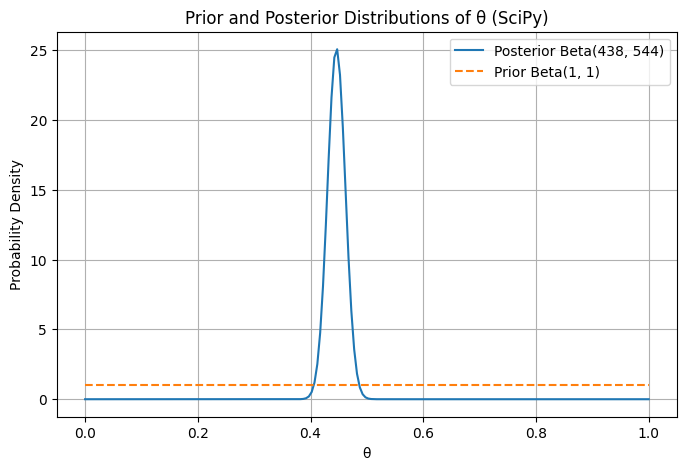

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Define the range of theta values to plot
theta_values = np.linspace(0, 1, 200)

# Calculate the probability density function (PDF) for the posterior Beta distribution
pdf_values_posterior = beta.pdf(theta_values, a_post, b_post)

# Calculate the probability density function (PDF) for the prior Beta distribution
pdf_values_prior = beta.pdf(theta_values, alpha0, beta0)

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(theta_values, pdf_values_posterior, label=f'Posterior Beta({a_post}, {b_post})')
plt.plot(theta_values, pdf_values_prior, label=f'Prior Beta({alpha0}, {beta0})', linestyle='--')


# Add labels and title
plt.xlabel('θ')
plt.ylabel('Probability Density')
plt.title('Prior and Posterior Distributions of θ (SciPy)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

### Summarize the posterior distribution directly by R

In [ ]:
%%R -i a_post,b_post,p0
cat(sprintf("Mean = %.3f\n", a_post/(a_post+b_post)))
cat(sprintf("Median = %.3f\n", qbeta(0.5,a_post,b_post)))
CI <- qbeta(c(0.025,0.975),a_post,b_post)
cat(sprintf("95%% CI = (%.3f, %.3f)\n", CI[1], CI[2]))
cat(sprintf("Pr(theta < %.3f) = %.3f",p0, pbeta(p0,a_post,b_post)))

Mean = 0.446
Median = 0.446
95% CI = (0.415, 0.477)
Pr(theta < 0.485) = 0.993

### Plot prior and postrior distributions in R

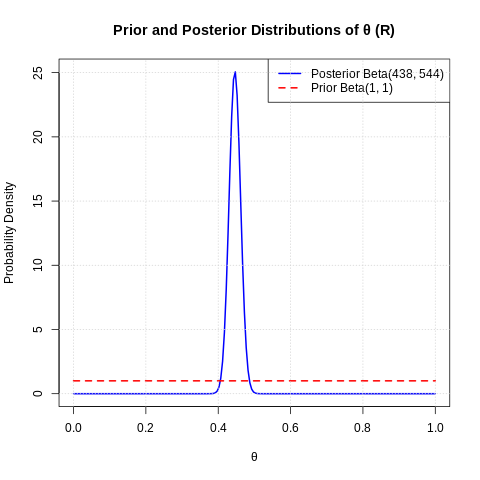

In [ ]:
%%R -i a_post,b_post,alpha0,beta0
# Generate theta values for plotting
theta_values <- seq(0, 1, length.out = 200)

# Calculate the probability density function (PDF) for the posterior Beta distribution
pdf_values_posterior <- dbeta(theta_values, shape1 = a_post, shape2 = b_post)

# Calculate the probability density function (PDF) for the prior Beta distribution
pdf_values_prior <- dbeta(theta_values, shape1 = alpha0, shape2 = beta0)

# Create the plot
plot(theta_values, pdf_values_posterior, type = "l", col = "blue", lwd = 2,
     xlab = "θ", ylab = "Probability Density",
     main = "Prior and Posterior Distributions of θ (R)")

# Add the prior distribution to the plot
lines(theta_values, pdf_values_prior, type = "l", col = "red", lwd = 2, lty = 2)

# Add a legend
legend("topright", legend = c(sprintf("Posterior Beta(%d, %d)", a_post, b_post), sprintf("Prior Beta(%d, %d)", alpha0, beta0)),
       col = c("blue", "red"), lty = c(1, 2), lwd = 2)

# Add a grid
grid()

### Summarize the posterior distribution using Monte Carlo Methods by PyMC

In [ ]:
# Import the pymc and arviz libraries for probabilistic programming and posterior analysis.
import pymc as pm
import arviz as az
# Import numpy for numerical operations, specifically for calculating the median.
import numpy as np

# Draw 100,000 samples from the posterior Beta distribution with the calculated parameters.
# A random seed is set for reproducibility.
theta_draws = pm.draw(pm.Beta.dist(a_post, b_post), draws=100_000, random_seed=2025)
# Calculate the mean of the drawn samples.
post_mean   = theta_draws.mean()
# Calculate the median of the drawn samples.
post_median = np.median(theta_draws)
# Calculate the 95% credible interval (CI) of the drawn samples using np.quantile.
hdi_low, hdi_high = np.quantile(theta_draws, [0.025, 0.975]).tolist()
# Calculate the proportion of samples less than p0 to estimate the probability.
pr_less     = (theta_draws < p0).mean()

# Print the calculated summary statistics from the Monte Carlo draws.
print(f"Mean={post_mean:.3f}")
print(f"Median={post_median:.3f}")
print(f"95% CI=({hdi_low:.3f}, {hdi_high:.3f})")
print(f"Pr(theta < {p0})={pr_less:.3f})")

Mean=0.446
Median=0.446
95% CI=(0.415, 0.477)
Pr(theta < 0.485)=0.993)


### Summarize the posterior distribution using Monte Carlo Methods by R

In [ ]:
%%R -i a_post,b_post,p0
R_samples <- rbeta(100000,a_post,b_post)
cat(sprintf("Mean = %.3f\n", mean(R_samples)))
cat(sprintf("Median = %.3f\n", median(R_samples)))
CI <- quantile(R_samples, c(0.025,0.975))
cat(sprintf("95%% CI = (%.3f, %.3f)\n", CI[1], CI[2]))
cat(sprintf("Pr(theta < %.3f) = %.3f",p0, mean(R_samples < p0)))

Mean = 0.446
Median = 0.446
95% CI = (0.415, 0.477)
Pr(theta < 0.485) = 0.993

## Example 2: Normal model with known variance unkown mean

Data: $y_i \sim N(\mu, 1)$ for $i = 1,\ldots, 10$.

Prior: $\mu \sim N(\zeta, \tau^2)$.

Posterior: $\mu \mid y \sim N(\tilde\zeta, \tilde\tau^2)$


\begin{eqnarray*}
\tilde \zeta = E(\mu \mid y) &=& (n\sigma^{-2} + \tau^{-2})^{-1} (n\sigma^{-2}\bar y + \tau^{-2}\zeta)\\
\tilde \tau^2 = \mathrm{Var}(\mu \mid y) & = &  (n\sigma^{-2} + \tau^{-2})^{-1}
\end{eqnarray*}


Posterior mean (zeta_tilde): 0.491
Posterior variance (tau2_tilde): 0.050


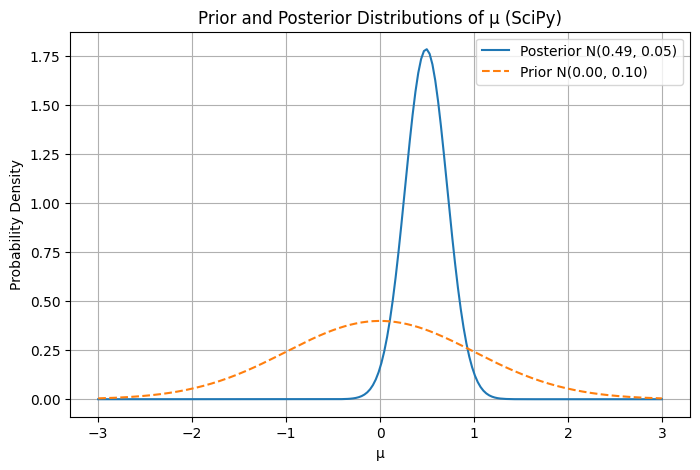

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define parameters for the normal likelihood
n = 10  # number of data points
sigma2 = 1  # variance of the data
y_bar = 0.982 # mean of the data

# Define parameters for the normal prior
zeta = 0  # mean of the prior
tau2 = 0.1  # variance of the prior


# Calculate parameters for the normal posterior
tau2_tilde = 1 / (n/sigma2 + 1/tau2)
zeta_tilde = tau2_tilde * (n/sigma2 * y_bar + 1/tau2 * zeta)

print(f"Posterior mean (zeta_tilde): {zeta_tilde:.3f}")
print(f"Posterior variance (tau2_tilde): {tau2_tilde:.3f}")

# Define the range of mu values to plot
mu_values = np.linspace(-3, 3, 200)

# Calculate the probability density function (PDF) for the posterior Normal distribution
pdf_values_posterior = norm.pdf(mu_values, loc=zeta_tilde, scale=np.sqrt(tau2_tilde))

# Calculate the probability density function (PDF) for the prior Normal distribution
pdf_values_prior = norm.pdf(mu_values, loc=zeta, scale=tau)

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(mu_values, pdf_values_posterior, label=f'Posterior N({zeta_tilde:.2f}, {tau2_tilde:.2f})')
plt.plot(mu_values, pdf_values_prior, label=f'Prior N({zeta:.2f}, {tau2:.2f})', linestyle='--')

# Add labels and title
plt.xlabel('μ')
plt.ylabel('Probability Density')
plt.title('Prior and Posterior Distributions of μ (SciPy)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()